In [175]:
import torch
import math

In [2]:
import lovely_tensors as lt
lt.monkey_patch()

# backward chaining

## Setup

In [132]:
import sys; sys.path.append('..')

In [133]:
# ! pip install lovely-tensors

import lovely_tensors as lt
lt.monkey_patch()

In [134]:
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torch.utils.data import DataLoader

from transformer_lens import HookedTransformer, HookedTransformerConfig

In [135]:
import wandb
from tqdm.auto import tqdm

from omegaconf import OmegaConf

from datetime import datetime

from pathlib import Path

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [240]:
import plotly.graph_objects as go
import numpy as np


def heatmap_plotly(matrix):
    # Create the heatmap
    fig = go.Figure(data=go.Heatmap(
            z=matrix,
    
            # hoverongaps=False,                      # Show values on hover even for gaps if any
            colorscale='Viridis'))                  # Color scheme
    
    # Update layout for better readability
    fig.update_layout(
        xaxis=dict(scaleanchor="y", scaleratio=1),  # Ensures x axis is scaled to y axis
        yaxis=dict(constrain='domain', autorange='reversed'),  # Reverses the y-axis
        xaxis_title='Column',
        yaxis_title='Row')
    
    # Show the plot
    fig.show()

In [241]:
from src.tree import list2tree
from src.tree_dataset import TreeDataset, parse_input_idx, input_tokens_to_tree, tree_to_edges
from src.utils import seed_all


from src.trainer import accuracy_by_depth
from src.trainer import TreeTrainer

In [242]:
conf = OmegaConf.load('../conf/00_reproduce_6L_nodes=16.yaml')

# Output is identical to the YAML file
conf.n_nodes = 16
conf.device = 'cpu'
print(OmegaConf.to_yaml(conf))

random_seed: 42
n_nodes: 16
model:
  d_model: 128
  d_head: 128
  n_layers: 6
  act_fn: gelu
  attention_dir: causal
optimizer:
  lr: 0.001
  weight_decay: 0.01
batch_size: 64
epoch_len_steps: 5000
checkpoint_every_epoch: 2
device: cpu
debug: false
use_wandb: true
wandb:
  project: reasoning-mech-interp
  name: 00_6L_nodes=16
max_iters: null



In [243]:
trainer = TreeTrainer(conf)

tokenizer = trainer.dataset.tokenizer

tok = tokenizer.tokenize
detok = tokenizer.detokenize


ROOT_DELIM_TOKEN_IDX = trainer.tok([':'])[0]

# state_dict = torch.load(REPRODUCED_MODEL_CKPT)
# trainer.model.load_state_dict(state_dict)

Moving model to device:  cpu


In [244]:
from transformer_lens import HookedTransformer, HookedTransformerConfig

In [245]:
# HookedTransformerConfig?

In [248]:
# model_cfg = HookedTransformerConfig(
# )

device = conf.device

# model = HookedTransformer(model_cfg).to(device)

## edge embedding head

Goal: store info (node_0, node_1) in different subspaces of x_1

Implementation: copy info about previous token into current one

### Checkpoint 0: attend to previous token

Implement attention to prev k token.

Input: 
  - d_model
  - k

Output:

 - pos embs
 - W_Q
 - W_K

In [249]:
d_model = 8
d_head = d_model

In [250]:
max_len = 100


position = torch.arange(max_len).unsqueeze(1)

div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
pe = torch.zeros(max_len, d_model)
pe[:, 0::2] = torch.sin(position * div_term)
pe[:, 1::2] = torch.cos(position * div_term)

In [251]:
pe

tensor[100, 8] n=800 (3.1Kb) x∈[-1.000, 1.000] μ=0.311 σ=0.635

In [252]:
def R_2d(a):

    return torch.tensor([
        [torch.cos(a), -torch.sin(a)],
        [torch.sin(a), torch.cos(a)]
    ])

In [253]:
U,S,V = torch.pca_lowrank(pe, q=8)
U

tensor[100, 8] n=800 (3.1Kb) x∈[-0.317, 0.325] μ=0.000 σ=0.100

In [254]:
W_K = U[:d_head]


In [255]:
U

tensor[100, 8] n=800 (3.1Kb) x∈[-0.317, 0.325] μ=0.000 σ=0.100

In [256]:
U[:d_head]

tensor[8, 8] n=64 x∈[-0.317, 0.325] μ=0.042 σ=0.133

In [257]:
Rot = torch.zeros(d_head, d_model)

In [265]:
for i,angle in enumerate(div_term):
    i_from = i * 2
    i_to   = (i + 1)* 2

    Rot[i_from:i_to, i_from:i_to] = R_2d(angle).T

In [266]:
Rot.v

tensor[8, 8] n=64 x∈[-0.841, 1.000] μ=0.110 σ=0.339
tensor([[ 0.5403,  0.8415,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.8415,  0.5403,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.9950,  0.0998,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0998,  0.9950,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.9999,  0.0100,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -0.0100,  0.9999,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0010],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0010,  1.0000]])

In [267]:
W_Q = Rot @ U[:d_head]

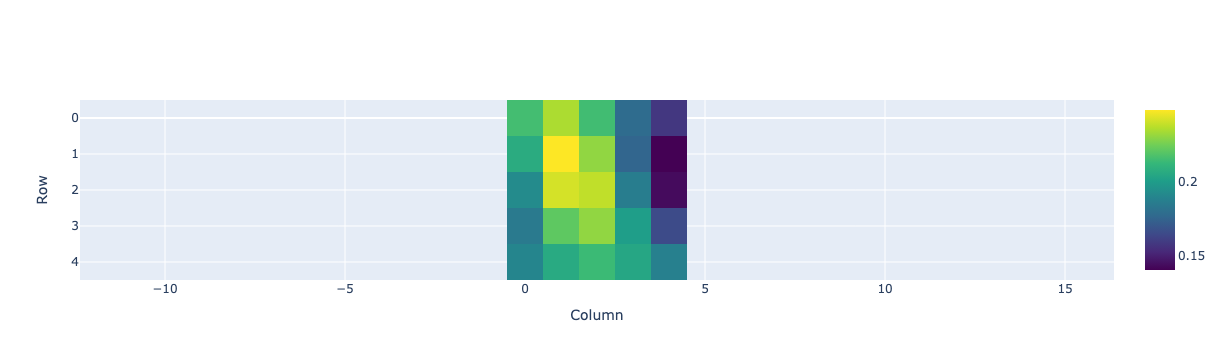

In [271]:
K = pe[:5] @ W_K.T
Q = pe[:5] @ W_Q.T

attn_scores = torch.einsum('qd,kd->qk', Q,K)


heatmap_plotly(attn_scores.softmax(dim=1))

In [272]:
attn_scores.softmax(dim=1)

tensor[5, 5] n=25 x∈[0.141, 0.248] μ=0.200 σ=0.030

# mathematical framework exercises

## Exercise 1 - $W_{OV}$

In [3]:
d_model = 16
d_head = 4

In [4]:
x_0 = 1 + torch.arange(d_model).float()

### (a) $W_V^1$​ and $W_{out}^1$

(a) Write down $W_V^1$​ and $W_{out}^1$ ​ for head 1, such that the head copies dimensions 0-3 of its input to 8-11 in its output.

In [5]:
W_V = torch.zeros(d_model, d_head)
W_V[:4] = torch.eye(4)
W_V.v

tensor[16, 4] n=64 x∈[0., 1.000] μ=0.062 σ=0.244
tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [6]:
(x_0@W_V).v

tensor[4] x∈[1.000, 4.000] μ=2.500 σ=1.291 [1.000, 2.000, 3.000, 4.000]
tensor([1., 2., 3., 4.])

In [7]:
W_O = torch.zeros(d_head, d_model)
W_O[:, 8:12] = torch.eye(4)
W_O.v

tensor[4, 16] n=64 x∈[0., 1.000] μ=0.062 σ=0.244
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [8]:
x_1 = ((x_0@W_V)@W_O)
x_1.v

tensor[16] x∈[0., 4.000] μ=0.625 σ=1.258
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 0., 0., 0., 0.])

In [9]:
(W_V@W_O).v

tensor[16, 16] n=256 (1Kb) x∈[0., 1.000] μ=0.016 σ=0.124
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

### (b) one more subspace

(b) Write down $W_{V}^2$ ​ and $W_{out}^2$ ​ for head 2, such that it copies 3 more dimensions of the previous token, and one dimension from two tokens ago (using a dimension written to by the previous head).

In [10]:
x_1[4:8] = 40 + torch.arange(4)

In [11]:
W_V2 = torch.zeros(d_model, d_head)
W_V2[4+0,0] = 1
W_V2[4+1,1] = 1
W_V2[4+2,2] = 1

W_V2[8,3] = 1

W_V2.v

tensor[16, 4] n=64 x∈[0., 1.000] μ=0.062 σ=0.244
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [12]:
x_1.v

tensor[16] x∈[0., 43.000] μ=11.000 σ=18.235
tensor([ 0.,  0.,  0.,  0., 40., 41., 42., 43.,  1.,  2.,  3.,  4.,  0.,  0.,
         0.,  0.])

In [13]:
(x_1@W_V2).v

tensor[4] x∈[1.000, 42.000] μ=31.000 σ=20.017 [40.000, 41.000, 42.000, 1.000]
tensor([40., 41., 42.,  1.])

In [14]:
W_O2 = torch.zeros(d_head, d_model)
W_O2[0, 4] = 1 # write to [4]
W_O2[1, 5] = 1 # write to [5]
W_O2[2, 6] = 1 # write to [6]
W_O2[3, 7] = 1 # write to [7]
W_O2.v

tensor[4, 16] n=64 x∈[0., 1.000] μ=0.062 σ=0.244
tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [15]:
x_2 = ((x_1@W_V2)@W_O2)
x_2.v

tensor[16] x∈[0., 42.000] μ=7.750 σ=16.503
tensor([ 0.,  0.,  0.,  0., 40., 41., 42.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.])

### (c) Expand

In [16]:
(W_V2 @ W_O2).v

tensor[16, 16] n=256 (1Kb) x∈[0., 1.000] μ=0.016 σ=0.124
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

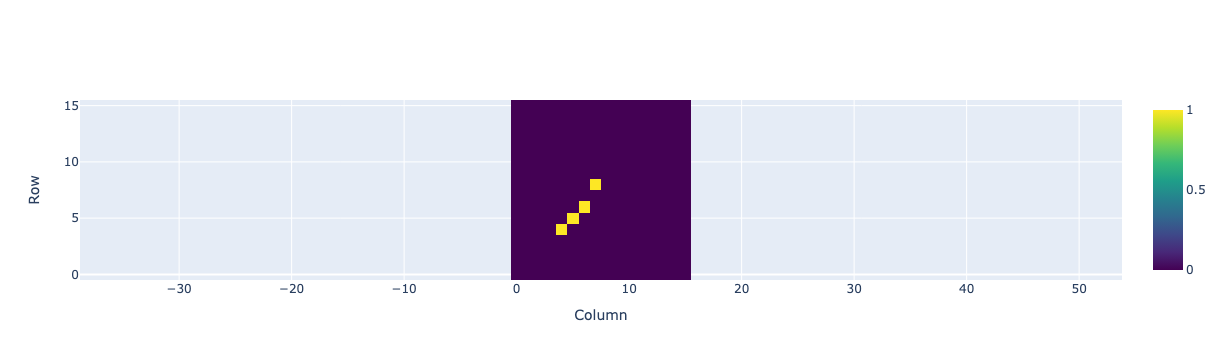

In [74]:
heatmap_plotly(W_V2 @ W_O2)

In [18]:
(W_V @ W_O).v

tensor[16, 16] n=256 (1Kb) x∈[0., 1.000] μ=0.016 σ=0.124
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

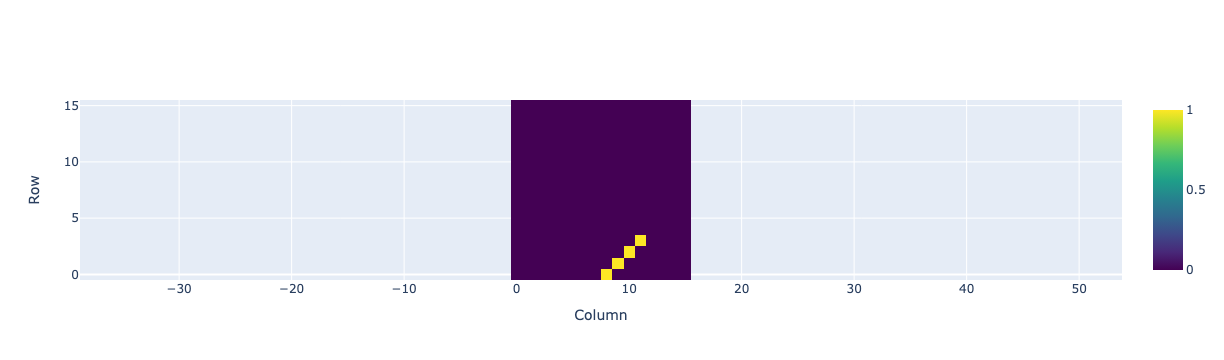

In [75]:
heatmap_plotly(W_V @ W_O)

## EXERCISE 2 - COPYING TEXT WITH AN INDUCTION HEAD (POINTER ARITHMETIC VERSION)

"pointer arithmetic" algorithm by hand

### (a) content self-select

$W_{K}$ and $W_{Q}$

(a) Let $u_{0}^{cont}$ , $u_{1}^{cont}$, $u_{n}^{cont}$ ​be the principal components of the content embedding. 


Write  $W_{K}$ and $W_{Q}$ ​for an attention head (with 4 dimensional queries and keys) 

selecting tokens with similar content to the present token, including the present token itself.

In [76]:
# are we given eigenvalues:?
# Are we going to rely only on the first d_head principal components, or agg them by eigenvalue?

In [77]:
d_model = 16
d_head = 4
seq_len = 8

d_model = 6

In [110]:


X_0 = 1. + torch.arange(d_model*seq_len).reshape(seq_len, d_model)

X_0[1:] = torch.randn_like(X_0[1:])

X_0[5:] = 2 + 3*torch.randn_like(X_0[5:])

X_0.v

tensor[8, 6] n=48 x∈[-4.969, 8.817] μ=1.237 σ=2.687
tensor([[ 1.0000e+00,  2.0000e+00,  3.0000e+00,  4.0000e+00,  5.0000e+00,
          6.0000e+00],
        [ 1.8790e+00,  3.9755e-01,  7.1572e-04, -1.5236e+00, -5.8173e-01,
          9.6097e-01],
        [-2.6027e-01, -1.4955e+00,  1.2159e+00,  7.6596e-02,  1.5178e+00,
          1.2779e+00],
        [ 1.4991e+00, -4.0876e-02, -1.9546e+00, -1.9137e+00, -3.3983e-01,
         -3.2112e-02],
        [-6.8768e-01, -1.7525e+00, -1.2251e+00, -9.5054e-01,  8.3652e-01,
         -4.9153e-02],
        [-2.5044e+00,  2.5319e+00, -5.9871e-02,  8.9750e-01, -4.9687e+00,
          2.3187e+00],
        [ 8.8175e+00,  1.5739e+00,  2.7639e+00,  5.7127e+00,  2.2365e+00,
          4.6293e+00],
        [ 4.1684e+00,  3.2535e+00,  2.2249e+00, -2.0452e+00,  7.5411e+00,
          2.4380e+00]])

In [111]:
U,S,V = torch.pca_lowrank(X_0)

U,S

(tensor[8, 6] n=48 x∈[-0.539, 0.667] μ=4.967e-09 σ=0.357,
 tensor[6] x∈[0.658, 13.551] μ=5.907 σ=4.757 [13.551, 8.572, 6.462, 4.515, 1.683, 0.658])

In [112]:
S.v

tensor[6] x∈[0.658, 13.551] μ=5.907 σ=4.757 [13.551, 8.572, 6.462, 4.515, 1.683, 0.658]
tensor([13.5506,  8.5715,  6.4616,  4.5146,  1.6827,  0.6585])

In [113]:
(X_0.T @ X_0).v

tensor[6, 6] n=36 x∈[13.633, 115.015] μ=40.128 σ=23.460
tensor([[108.7139,  25.3792,  34.3919,  38.5004,  66.0255,  52.6331],
        [ 25.3792,  28.9402,  17.8460,  13.6334,  21.5216,  31.6473],
        [ 34.3919,  17.8460,  28.3928,  28.1822,  39.7420,  37.7579],
        [ 38.5004,  13.6334,  28.1822,  60.5163,  13.7519,  46.2825],
        [ 66.0255,  21.5216,  39.7420,  13.7519, 115.0154,  48.5683],
        [ 52.6331,  31.6473,  37.7579,  46.2825,  48.5683,  71.3108]])

In [114]:
# W_K = torch.zeros(d_model, d_head)
# W_K[:4] = torch.eye(4)

# W_Q = W_K
# W_K.v

W_K = U[:d_head].T
W_Q = W_K

W_K.v

tensor[6, 4] n=24 x∈[-0.537, 0.667] μ=0.077 σ=0.340
tensor([[ 0.3724, -0.1842, -0.1303, -0.2751],
        [-0.1613,  0.0599,  0.1021,  0.1721],
        [ 0.6622, -0.2614,  0.1575, -0.3489],
        [ 0.1514, -0.1627,  0.4740, -0.0527],
        [-0.3130,  0.3549,  0.6177, -0.5374],
        [ 0.3885,  0.6673, -0.1021,  0.2054]])

In [115]:
U[:4]

tensor[4, 6] n=24 x∈[-0.537, 0.667] μ=0.077 σ=0.340

In [116]:
S

tensor[6] x∈[0.658, 13.551] μ=5.907 σ=4.757 [13.551, 8.572, 6.462, 4.515, 1.683, 0.658]

In [117]:
K = (X_0@W_K)
K.v

tensor[8, 4] n=32 x∈[-4.807, 6.823] μ=0.713 σ=2.550
tensor([[ 3.4076,  4.2793,  4.9188, -2.6427],
        [ 0.9609,  0.3602, -1.3838,  0.1416],
        [ 0.9823,  1.0196,  0.9163, -1.1673],
        [-0.9252,  0.4016, -1.6213,  0.5394],
        [-1.2095,  0.7606, -0.2111, -0.0946],
        [ 1.2113,  0.2663, -2.3052,  4.2448],
        [ 6.8230,  0.7015,  3.0643, -3.6709],
        [ 0.7780,  3.4819,  3.5794, -4.8069]])

In [118]:
Q = (X_0 @ W_Q)
Q.v

tensor[8, 4] n=32 x∈[-4.807, 6.823] μ=0.713 σ=2.550
tensor([[ 3.4076,  4.2793,  4.9188, -2.6427],
        [ 0.9609,  0.3602, -1.3838,  0.1416],
        [ 0.9823,  1.0196,  0.9163, -1.1673],
        [-0.9252,  0.4016, -1.6213,  0.5394],
        [-1.2095,  0.7606, -0.2111, -0.0946],
        [ 1.2113,  0.2663, -2.3052,  4.2448],
        [ 6.8230,  0.7015,  3.0643, -3.6709],
        [ 0.7780,  3.4819,  3.5794, -4.8069]])

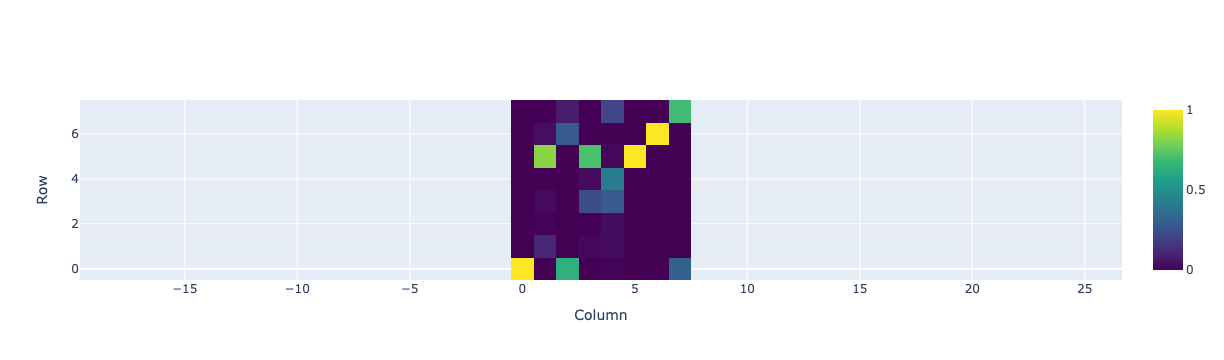

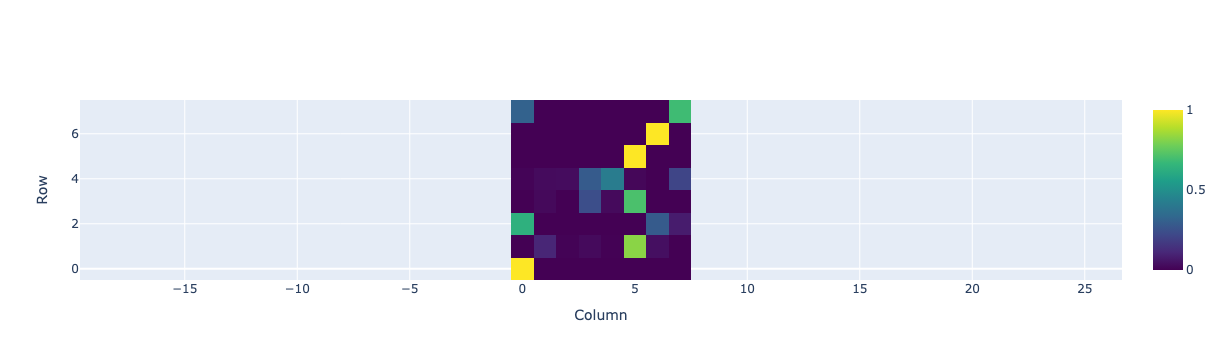

In [123]:
attn_scores = torch.einsum('qd,kd->qk', Q,K)

heatmap_plotly(attn_scores.softmax(dim=0))
heatmap_plotly(attn_scores.softmax(dim=1))

### (b) pos self-select!

#### nerf pos enc

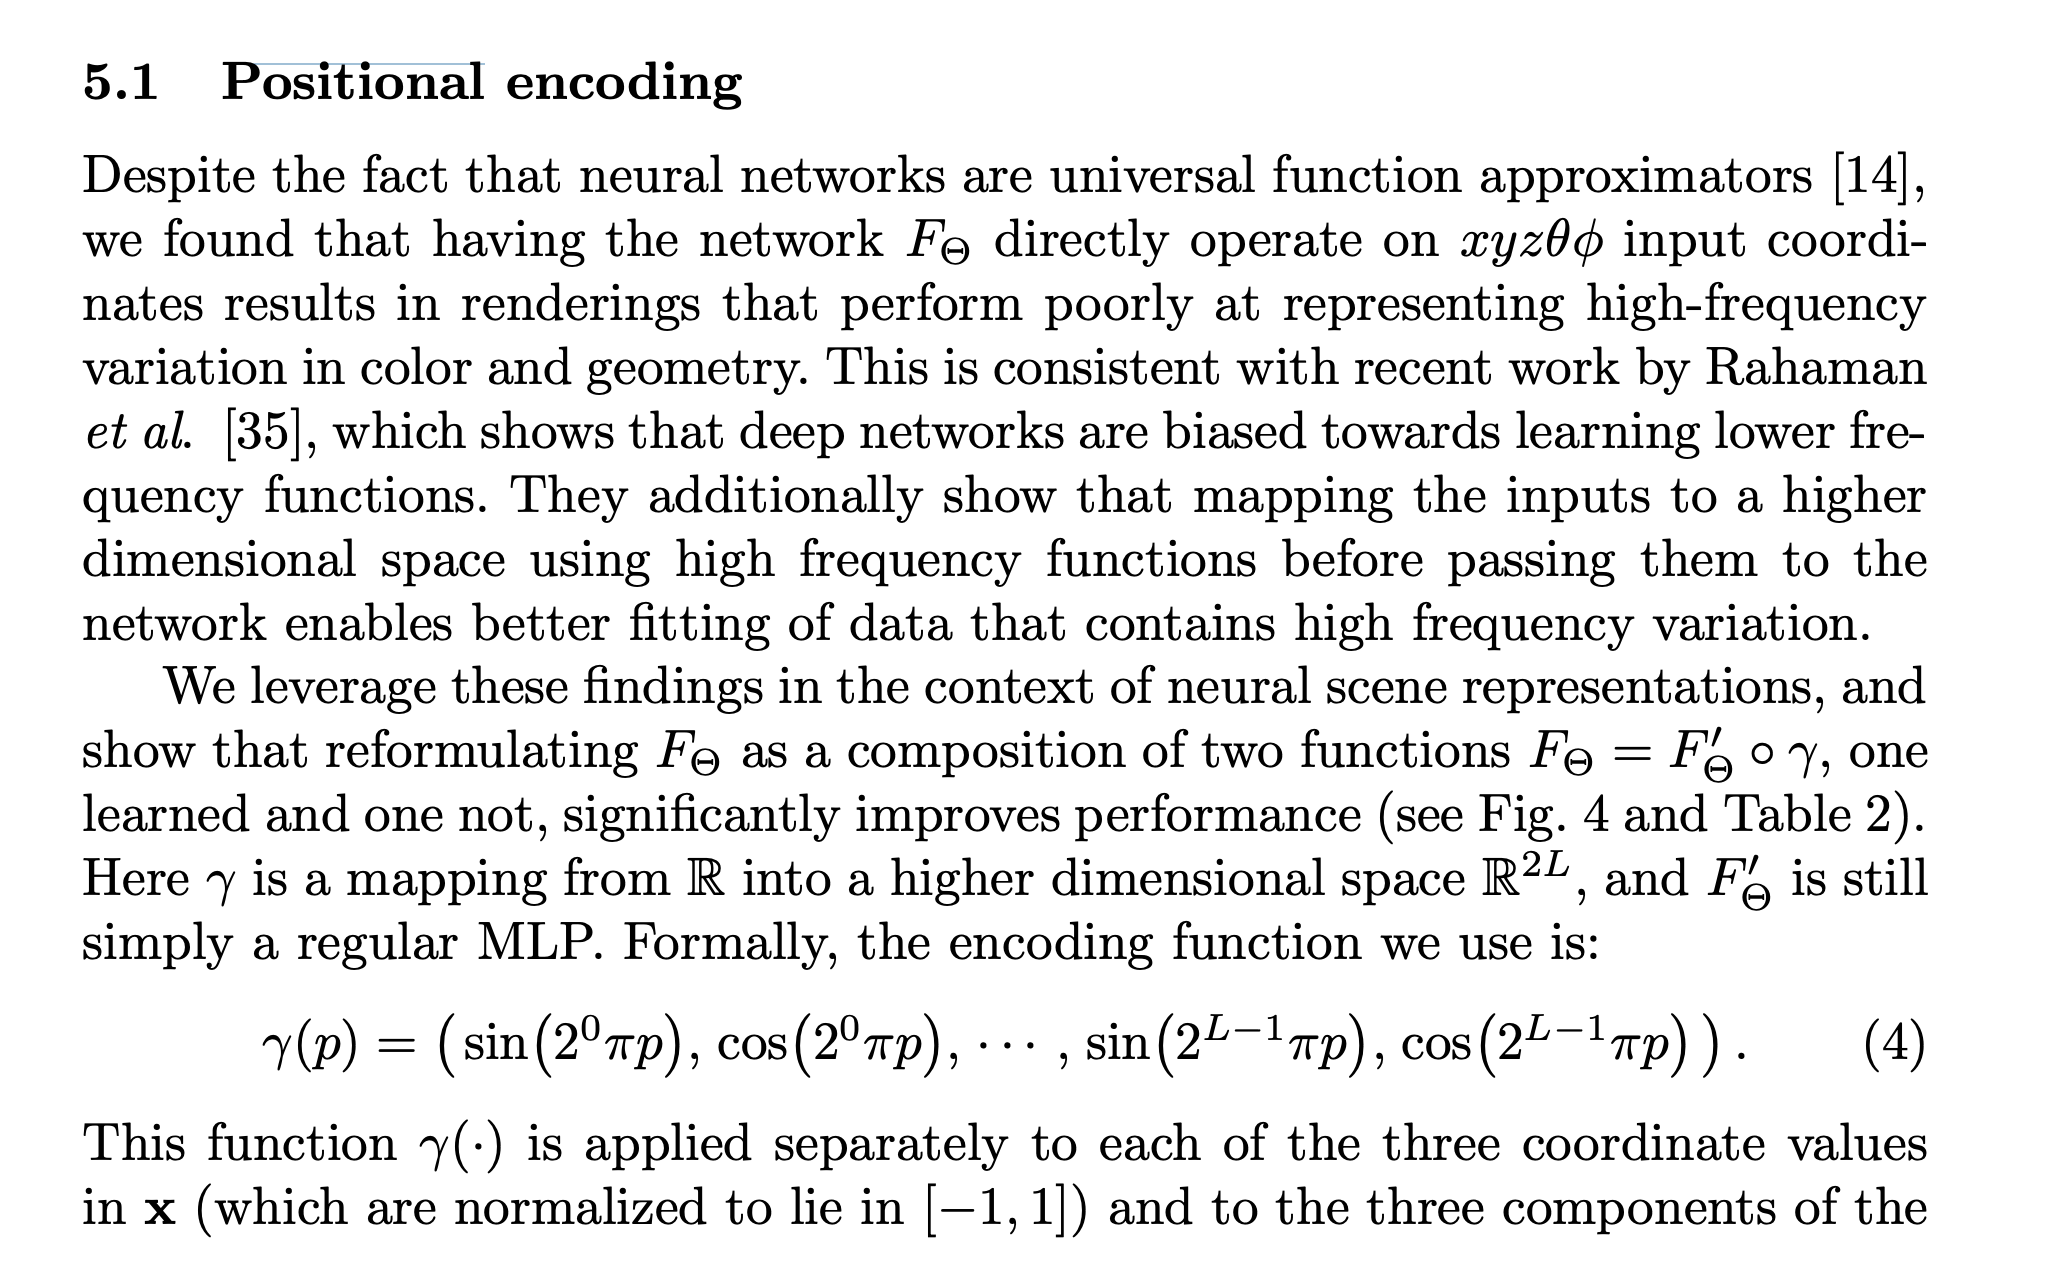

#### 🤖 original (2017)

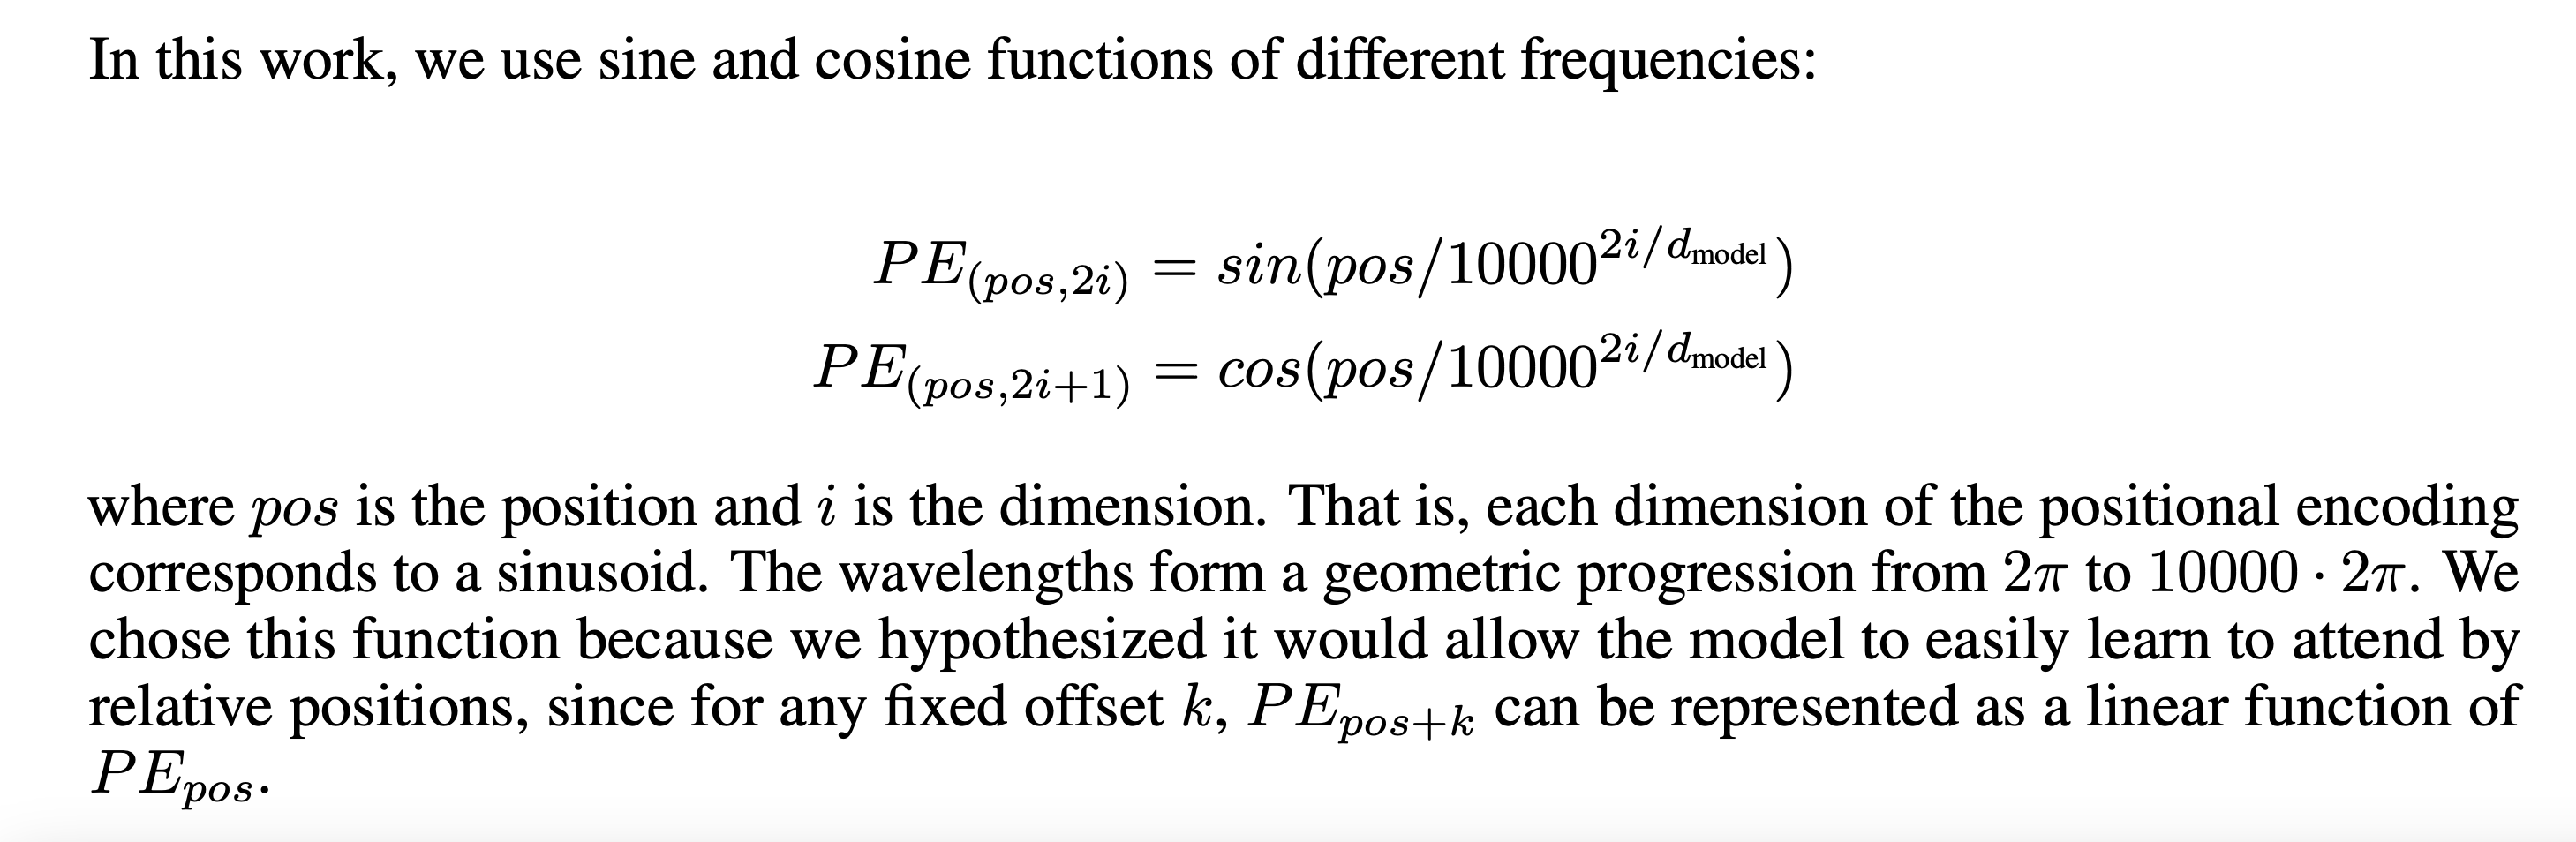

In [176]:
max_len = 100


position = torch.arange(max_len).unsqueeze(1)

div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
pe = torch.zeros(max_len, d_model)
pe[:, 0::2] = torch.sin(position * div_term)
pe[:, 1::2] = torch.cos(position * div_term)

#### for any fixed offset $k$, $PE_{pos+k}$ can be represented as a linear function of $PE_{pos}$

 - [x] Why and how?
   - [x] Semi-satisfiable answer: because we can conceive pos_emb as points on unit circle → do rotation, which is a linear

In [155]:
type(torch.tensor(1.))

torch.Tensor

In [168]:
def R_2d(a):

    return torch.tensor([
        [torch.cos(a), -torch.sin(a)],
        [torch.sin(a), torch.cos(a)]
    ])

In [171]:
pe[2, :2] @ R_2d(div_term[0]).T

tensor[2] μ=0.691 σ=0.213 [0.841, 0.540]

In [165]:
pe[1, :2]

tensor[2] μ=0.691 σ=0.213 [0.841, 0.540]